In [8]:
#all imports
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import img_to_array
from keras._tf_keras.keras.utils import to_categorical, plot_model
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [9]:
epochs = 100 #how many times it reads through is what epochs is. 
lr = 1e-3 #learning rate
batch_size = 64 #how many images to look at a time
img_dims = (96,96,3) # Height, width, num of RGB channels

In [10]:
data = []
labels = []
#arrays for data and labels 
image_files = [f for f in glob.glob(r'C:/Users/sheet/OneDrive/Desktop/AIM Project/asl_alphabet_train' + "/**/*", recursive=True) if not os.path.isdir(f)]
#takes the image files from the files and then put it in the arrays
random.shuffle(image_files) #shuffling the image files. 
#glob.glob is like a library that reads in data files and searching for files that follow a data pattern. 

In [11]:
# Adds images to array, also gives it a label
for img in image_files:
    image = cv2.imread(img)#look at image
    image = cv2.resize(image, (img_dims[0], img_dims[1])) # Resizes every image to be the same size. 
    image = img_to_array(image)#convert to array
    data.append(image)#add to data list 

    label = img.split(os.path.sep)[-2]#add label to each image classifying what the alphabet is for each image. 
    label = ord(label) - ord('A') # Convert label to numerical value (0-25)
    labels.append([label])# actually add to data list. 

# Data pre-processing, converts data and labels to numpy array (Easier for computer to work with numpy arrays instead of normal arrays. )
try:
    data = np.array(data, dtype='float') / 255.0 
    labels = np.array(labels)
except Exception as e:
    print(f"Error converting data to numpy array: {e}")

In [12]:
# Splits dataset into training and testing
# test_size = 0.2 means that 20% of the dataset will be used for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=26)#we have 26 folders for 26 aplhabets. 
testY = to_categorical(testY, num_classes=26)

# Augmentation of dataset (Changes and adds error and adds altered version of the training data.)
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [14]:
# Height and width of image (96 x 96)
# Depth is RGB values
# Classes is number of categories (2 in our case because male/female)
def build(height, width, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # Need to check whether channels are first or last
    if K.image_data_format() == 'channels_first':
        inputShape = (depth, height, width)
        chanDim = 1
    
    # Adding convolution layer
    model.add(Conv2D(32, (3,3), padding='same', input_shape=inputShape)) # 32 filters, 3x3 image - passes over picture to highlight features
    model.add(Activation('relu')) #chooses what is actually a distinguishing feature
    model.add(BatchNormalization(axis=chanDim)) # Normalizing the values 
    # (Some data points may have high value, others may be low, causing the higher values to overshadow the lower values)
    # Max pooling, done to reduce unwanted values AKA noise in data set
    model.add(MaxPooling2D(pool_size=(3,3))) #ignores unwanted things in a dataset - only done on half
    model.add(Dropout(0.25)) # Prevents overfitting - ignores some of the dataset

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    '''
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    '''
    model.add(Flatten()) # Flattened so our layers are 1D to be passed into dense layer
    model.add(Dense(1024)) #combines all feature map patterns to make prediction
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation('softmax')) #  probability of class - prob of a for example

    return model

In [15]:
# Builds the model
model = build(width = img_dims[0], height = img_dims[1], depth = img_dims[2], classes = 26)

# Compiles the model
opt = Adam(learning_rate = lr, decay = lr/epochs)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# Trains the model
H = model.fit(aug.flow(trainX, trainY, batch_size = batch_size), validation_data = (testX,testY), 
                        steps_per_epoch = len(trainX) // batch_size, epochs = epochs, verbose = 1)

# Saves model to the disk
model.save('sign_language_detection.keras')

c:\Users\sheet\OneDrive\Desktop\AIM Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\sheet\OneDrive\Desktop\AIM Project\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100


c:\Users\sheet\OneDrive\Desktop\AIM Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.1510 - loss: 4.5043 - val_accuracy: 0.0411 - val_loss: 4.8853
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3281 - loss: 3.2054

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3281 - loss: 3.2054 - val_accuracy: 0.0411 - val_loss: 5.2413
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3804 - loss: 2.2827 - val_accuracy: 0.0274 - val_loss: 6.2564
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.4688 - loss: 1.9120 - val_accuracy: 0.0274 - val_loss: 6.2528
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4669 - loss: 2.0536 - val_accuracy: 0.0274 - val_loss: 5.7906
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5469 - loss: 1.8150 - val_accuracy: 0.0274 - val_loss: 5.6881
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5387 - loss: 1.6302 - val_accuracy: 0.0274 - val_loss: 5.1409
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6406 - loss: 1.2090 - val_accuracy: 0.0274 - val_loss: 4.9466
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6344 - loss: 1.1873 - val_accuracy: 0.0274 - val_loss: 4.2524
Epoch 1

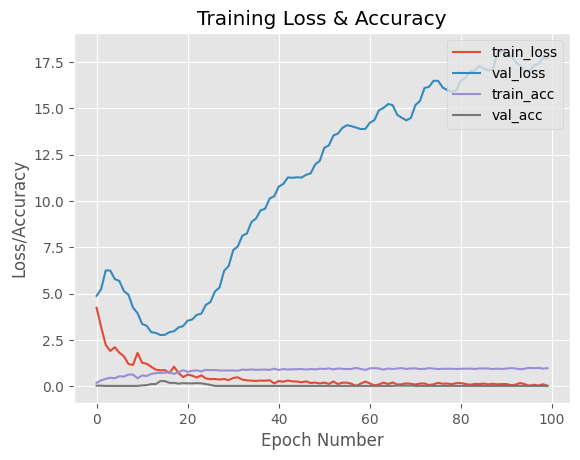

In [16]:
# Plot the training and validation loss and accuracy

plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss & Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')